# Vacancy formation energy and volume from implicit derivative

In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

# Local imports
from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools, \
                                      compute_energy_volume, create_perturbed_system, run_npt_implicit_derivative
from lammps_implicit_der.systems import BccVacancy, Bcc
#from lammps_implicit_der.tools.error_tools import coord_error

plotparams = plot_tools.plotparams.copy()
plotparams['figure.figsize'] = (9, 6)
plotparams['font.size'] = 16
plotparams['figure.subplot.wspace'] = 0.2
plt.rcParams.update(plotparams)

# Create the W bcc pure and vacancy systems

In [2]:
ncell_x = 2
alat = 3.18427
alat_vac = 3.163

bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure.Natom=}')
print(f'{bcc_pure.energy=:.3f}')
print(f'{bcc_vac.Natom=}')
print(f'{bcc_vac.energy=:.3f}')

bcc_pure.Natom=16
bcc_pure.energy=70.869
bcc_vac.Natom=15
bcc_vac.energy=69.569


## Energy-volume curve

In [3]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
bcc_pure_tmp = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac_tmp = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array)
energy_array_vac, volume_array_vac, virial_array_vac, pressure_array_vac = compute_energy_volume(bcc_vac_tmp, epsilon_array)

In [4]:
def get_min(energy_array, volume_array, pressure_array, ncell_x):
    min_idx = np.argmin(energy_array)

    energy_min = energy_array[min_idx]
    volume_min = volume_array[min_idx]
    pressure_min = pressure_array[min_idx]

    alat_min = volume_min**(1/3) / ncell_x

    return energy_min, volume_min, pressure_min, alat_min

energy_pure_min, volume_pure_min, pressure_pure_min, alat_pure_min = \
    get_min(energy_array_pure, volume_array_pure, pressure_array_pure, ncell_x)

print('Pure bcc:')
print(f'{energy_pure_min=:.3f}')
print(f'{volume_pure_min=:.3f}')
print(f'{pressure_pure_min=:.3f}')
print(f'{alat_pure_min=:.3f}')
print('')

energy_vac_min, volume_vac_min, pressure_vac_min, alat_vac_min = \
    get_min(energy_array_vac, volume_array_vac, pressure_array_vac, ncell_x)

print('Vacancy bcc:')
print(f'{energy_vac_min=:.3f}')
print(f'{volume_vac_min=:.3f}')
print(f'{pressure_vac_min=:.3f}')
print(f'{alat_vac_min=:.3f}')

Pure bcc:
energy_pure_min=0.000
volume_pure_min=258.297
pressure_pure_min=-0.003
alat_pure_min=3.184

Vacancy bcc:
energy_vac_min=0.000
volume_vac_min=253.156
pressure_vac_min=0.081
alat_vac_min=3.163


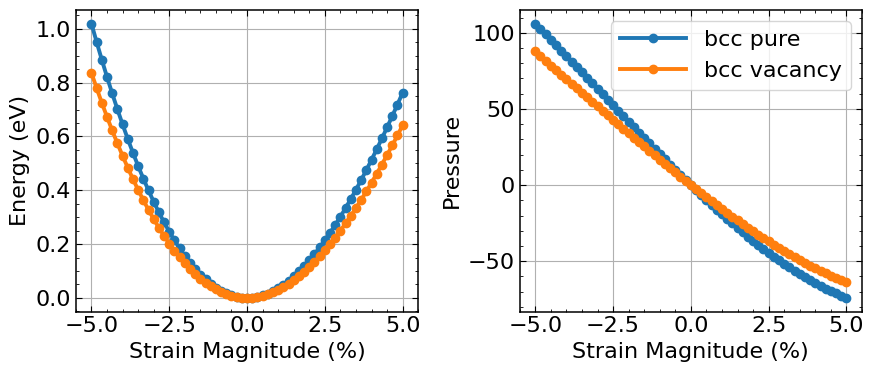

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

axes[1].plot(100.0 * epsilon_array, pressure_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_vac, label='bcc vacancy', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

## Interpolation of virial and its derivative

In [6]:
spline_list_pure = []
spline_list_vac = []

for idesc in range(bcc_pure.Ndesc):

    virial_trace_array_pure = np.sum(virial_array_pure[:, :3, :], axis=1) / 3.0
    spline_list_pure.append(CubicSpline(volume_array_pure, virial_trace_array_pure[:, idesc]))

    virial_trace_array_vac = np.sum(virial_array_vac[:, :3, :], axis=1) / 3.0
    spline_list_vac.append(CubicSpline(volume_array_vac, virial_trace_array_vac[:, idesc]))

virial_der_pure0 = np.array([spline_list_pure[idesc](volume_pure_min, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_vac0 = np.array([spline_list_vac[idesc](volume_vac_min, nu=1) for idesc in range(bcc_vac.Ndesc)])

# Perturb parameters and compute formation volumes and energies

### Implicit derivative - inhomogeneous contribution

In [7]:
# Re-define the same systems
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_vac = BccVacancy(alat=alat_vac, ncell_x=ncell_x, minimize=True, logname='bcc_vac.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

dX_dTheta_pure_inhom = bcc_pure.implicit_derivative(method='inverse')
dX_dTheta_vac_inhom = bcc_vac.implicit_derivative(method='inverse')

bcc_pure.compute_virial()
bcc_pure.gather_virial()
virial_pure = np.sum(bcc_pure.virial, axis=0)
virial_trace_pure = np.sum(virial_pure[:3, :], axis=0) / 3.0

bcc_vac.compute_virial()
bcc_vac.gather_virial()
virial_vac = np.sum(bcc_vac.virial, axis=0)
virial_trace_vac = np.sum(virial_vac[:3, :], axis=0) / 3.0

### Ensemble of Tungsten potentials

In [8]:
path = '../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

In [9]:
sample = 1
data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename = 'W_NEW.snapparam'

#delta_array = np.linspace(-20.0, 20.0, 5)
delta_array = np.array([-25.0, -10.0, 0.0, 10.0, 25.0, 50.0, 100.0])
ndelta = len(delta_array)

bcc_pure_list = []
bcc_vac_list = []

for i, delta in enumerate(delta_array):
    print('\n'+'*'*80)
    print(f'{i+1}/{len(delta_array)}, {delta=:.1f}')
    #print('Pure:')
    bcc_pure_list.append(run_npt_implicit_derivative(Bcc, alat, ncell_x, Theta_ens, delta, sample,
                                                     data_path, snapcoeff_filename, snapparam_filename,
                                                     virial_trace_pure, virial_der_pure0,
                                                     dX_dTheta_pure_inhom, dX_dTheta_full=None))

    #print('Vacancy:')
    bcc_vac_list.append(run_npt_implicit_derivative(BccVacancy, alat_vac, ncell_x, Theta_ens, delta, sample,
                                                    data_path, snapcoeff_filename, snapparam_filename,
                                                    virial_trace_vac, virial_der_vac0,
                                                    dX_dTheta_vac_inhom, dX_dTheta_full=None))


********************************************************************************
1/7, delta=-25.0
Overwriting ./perturb.snapcoeff
Saved SNAP coefficients to ./perturb.snapcoeff
Saved SNAP parameters to ./perturb.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log perturb.log

Setting SNAP potential



                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 6 steps
Initial fmax: 1.169e-14, final fmax: 2.082e-14
Initial fnorm: 4.525e-14, final fnorm: 7.826e-14
Number of atoms: 16, largest force value: 2.082e-14, force norm: 7.826e-14
s_box_relax.pot.Theta_dict[el]['beta0']=0.0
s_test.pot.Theta_dict[el]['beta0']=0.0
energy0=70.86859223792023, energy_true=-168.2572901240696, energy_hom_pred=70.90027786864842, energy_inhom_pred=70.86859223792024, energy_full_pred=70.90027786864839
Overwriting ./perturb.snapcoeff
Saved SNAP coefficients to ./perturb.snapcoeff
Saved SNAP parameters to ./perturb.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen non

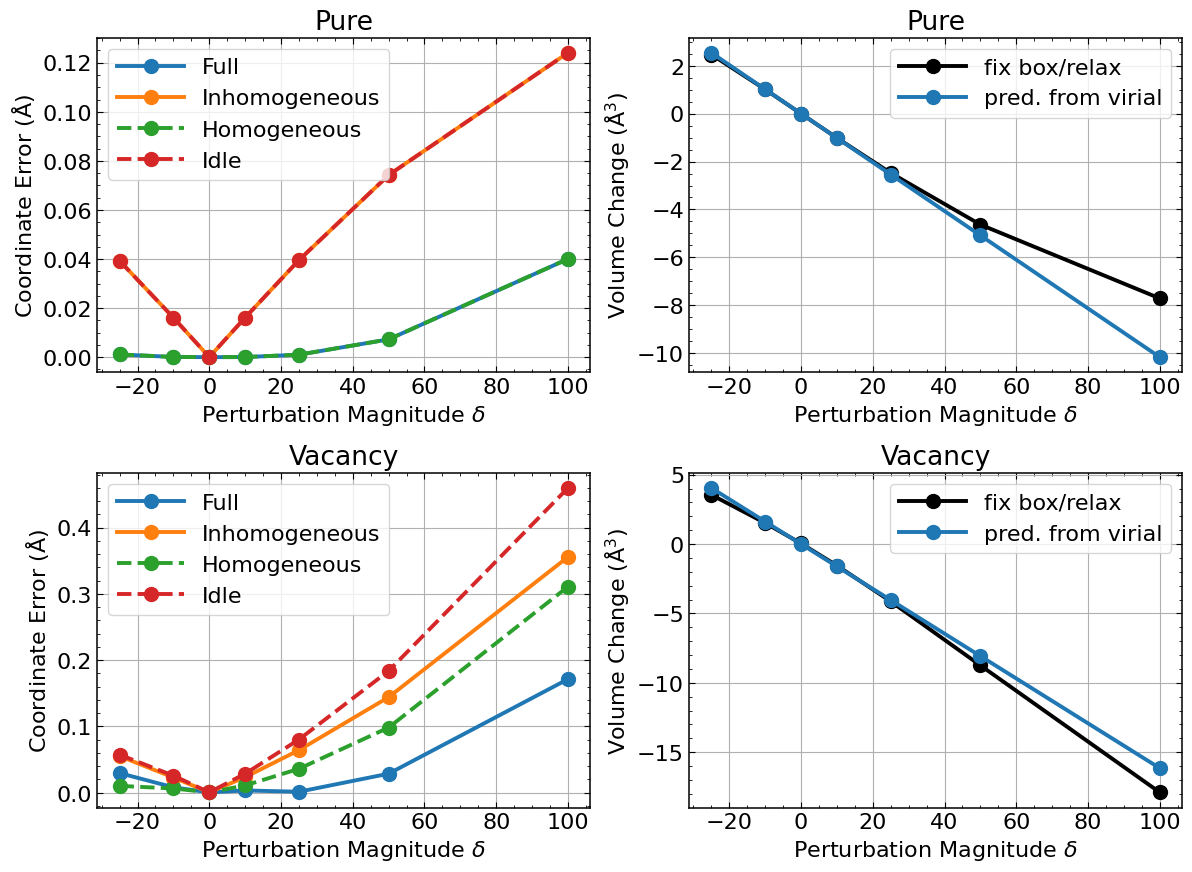

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.3)

error_axes = [axes[0, 0], axes[1, 0]]
data_lists = [bcc_pure_list, bcc_vac_list]
title_list = ['Pure', 'Vacancy']

for i, (data_list, ax) in enumerate(zip(data_lists, error_axes)):

    ax.plot(delta_array,
            [data_list[i]['coord_error_full'] for i in range(ndelta)],
            label='Full', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_inhom'] for i in range(ndelta)],
            label='Inhomogeneous', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_hom'] for i in range(ndelta)],
            label='Homogeneous', marker='o', ls='--')
    ax.plot(delta_array,
            [data_list[i]['coord_error_idle'] for i in range(ndelta)],
            label='Idle', ls='--', marker='o')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Coordinate Error ($\mathrm{\AA}$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

vol_axes = [axes[0, 1], axes[1, 1]]

for i, (data_list, ax) in enumerate(zip(data_lists, vol_axes)):

    vol0 = data_list[i]['volume0']
    ax.plot(delta_array,
            [data_list[i]['volume_true'] - vol0 for i in range(ndelta)],
            label='fix box/relax', marker='o', c='black')
    ax.plot(delta_array,
            [data_list[i]['volume_pred'] - vol0 for i in range(ndelta)],
            label='pred. from virial', marker='o', c='tab:blue')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Volume Change ($\mathrm{\AA}^3$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

plt.show()

In [17]:
def compute_formation_property(Natom_vac, Natom_pure, vac_list, pure_list, property_name):

    ndelta = len(vac_list)
    prop_pure = np.array([vac_list[i][property_name] for i in range(ndelta)])
    prop_vac = np.array([pure_list[i][property_name] for i in range(ndelta)])
    #print(f'{prop_vac=} {prop_pure=} {Natom_vac=} {Natom_pure=}')
    prop_formation = prop_vac - prop_pure * Natom_vac / Natom_pure

    return prop_formation

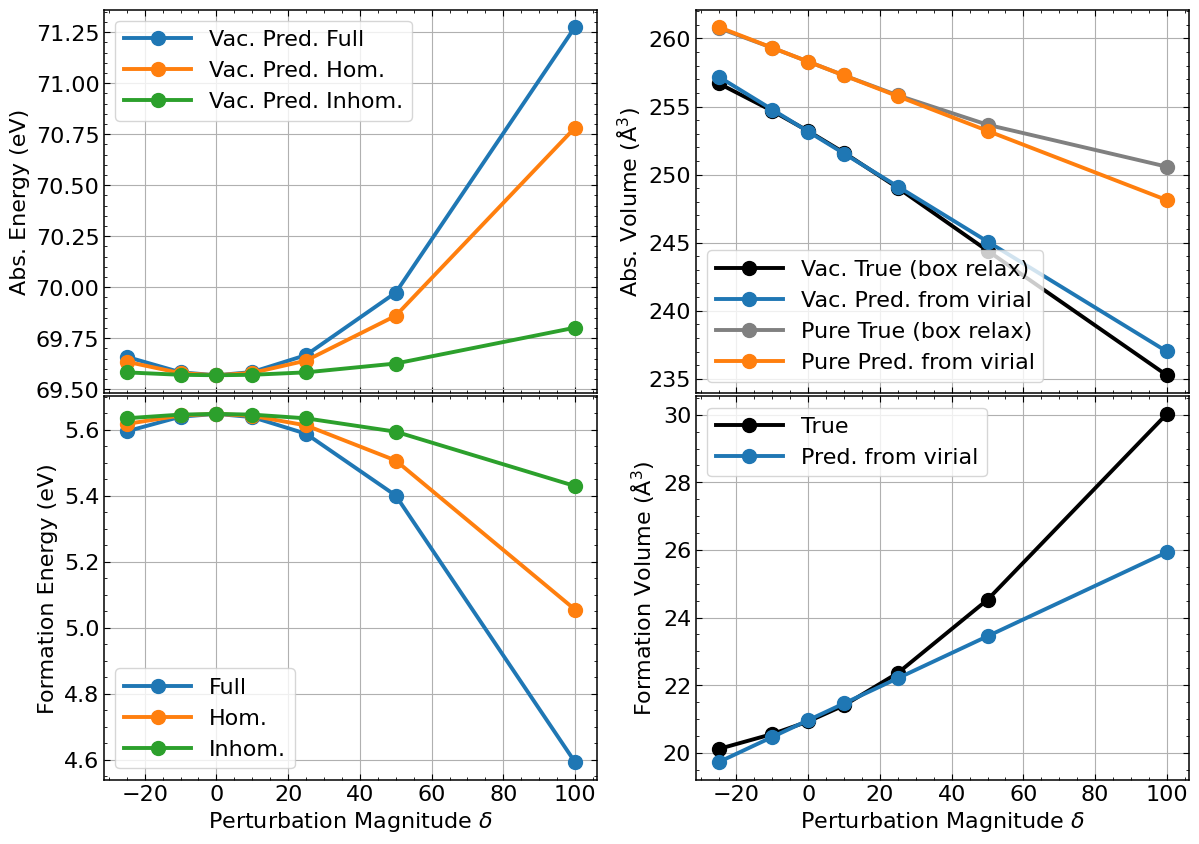

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy
#plot_energy_true = True
plot_energy_true = False
if plot_energy_true:
    axes[0, 0].plot(delta_array,
                    [bcc_vac_list[i]['energy_true'] for i in range(ndelta)],
                    label='Vac. True (box relax)', marker='o', c='black')

#plot_energy_true2 = True
plot_energy_true2 = False
if plot_energy_true2:
    axes[0, 0].plot(delta_array,
                    [bcc_vac_list[i]['energy_true2'] for i in range(ndelta)],
                    label='Vac. True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_full_pred'] for i in range(ndelta)],
                label='Vac. Pred. Full', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_hom_pred'] for i in range(ndelta)],
                label='Vac. Pred. Hom.', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_inhom_pred'] for i in range(ndelta)],
                label='Vac. Pred. Inhom.', marker='o')

#axes[0, 0].set_xlabel('Perturbation Magnitude $\delta$')
# remove tick labels
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylabel('Abs. Energy (eV)')

# Formation energies
Natom_pure = bcc_pure.Natom
Natom_vac = bcc_vac.Natom
E_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_full_pred')
E_form_hom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_hom_pred')
E_form_inhom_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_inhom_pred')
E_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'energy_true')

axes[1, 0].plot(delta_array, E_form_full_pred, label='Full', marker='o')
axes[1, 0].plot(delta_array, E_form_hom_pred, label='Hom.', marker='o')
axes[1, 0].plot(delta_array, E_form_inhom_pred, label='Inhom.', marker='o')
#axes[1, 0].plot(delta_array, E_form_true, label='True', marker='o', c='black')

axes[1, 0].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 0].set_ylabel('Formation Energy (eV)')

# Absolute volume
axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_true'] for i in range(ndelta)],
          label='Vac. True (box relax)', marker='o', c='black')

axes[0, 1].plot(delta_array,
          [bcc_vac_list[i]['volume_pred'] for i in range(ndelta)],
          label='Vac. Pred. from virial', marker='o')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_true'] for i in range(ndelta)],
          label='Pure True (box relax)', marker='o', c='gray')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_pred'] for i in range(ndelta)],
          label='Pure Pred. from virial', marker='o')


axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylabel('Abs. Volume ($\mathrm{\AA}^3$)')

# Formation volume
vol_form_full_pred = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_pred')
vol_form_true = compute_formation_property(Natom_vac, Natom_pure, bcc_vac_list, bcc_pure_list, 'volume_true')

axes[1, 1].plot(delta_array, vol_form_true, label='True', marker='o', c='black')
axes[1, 1].plot(delta_array, vol_form_full_pred, label='Pred. from virial', marker='o')

axes[1, 1].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 1].set_ylabel('Formation Volume ($\mathrm{\AA}^3$)')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


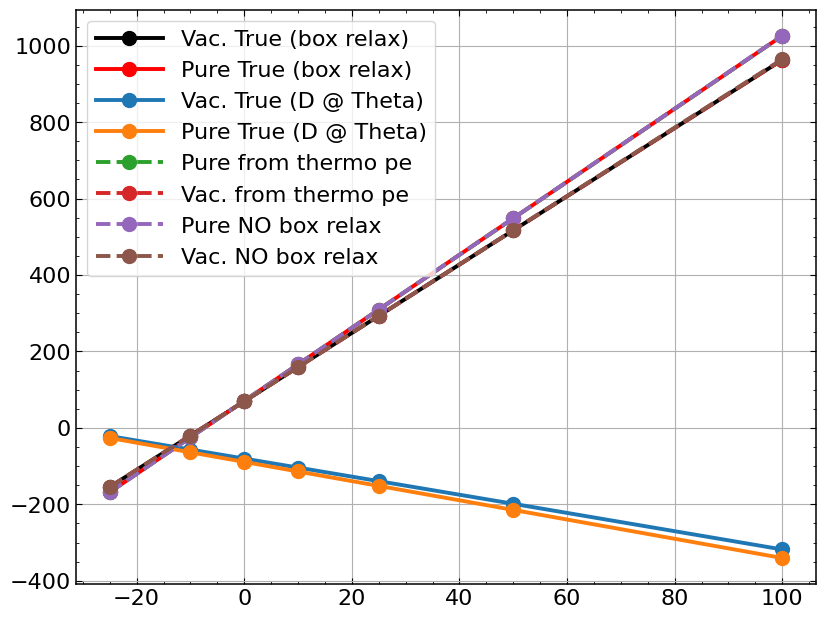

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Makes axes[0, 0] the largest and hide the other axes
for ax in axes.flatten():
    ax.set_visible(False)

axes[0, 0].set_visible(True)

# change the axes[0, 0] size
pos1 = axes[0, 0].get_position() # get the original position
pos2 = [pos1.x0, pos1.y0,  pos1.width*1.5, pos1.height*1.5]
axes[0, 0].set_position(pos2)

# Absolute energy

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true'] for i in range(ndelta)],
                label='Vac. True (box relax)', marker='o', c='black')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true'] for i in range(ndelta)],
                label='Pure True (box relax)', marker='o', c='red')


axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true2'] for i in range(ndelta)],
                label='Vac. True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true2'] for i in range(ndelta)],
                label='Pure True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_true3'] for i in range(ndelta)],
                label='Pure from thermo pe', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_true3'] for i in range(ndelta)],
                label='Vac. from thermo pe', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_pure_list[i]['energy_test'] for i in range(ndelta)],
                label='Pure NO box relax', marker='o', ls='--')

axes[0, 0].plot(delta_array,
                [bcc_vac_list[i]['energy_test'] for i in range(ndelta)],
                label='Vac. NO box relax', marker='o', ls='--')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

plt.show()

In [14]:
element = bcc_pure.pot.elem_list[0]
print(bcc_pure.pot.Theta_dict[element]['beta0'])

0.0
